In [ ]:
# let's build a bigram language model here :) 

## In bigram language modelling we only work with 2 characters at a time 
## Only looking at one character which is given, then model try to predict next character. 
## It only look at previous character to find the next character!! 

In [1]:
# let's explore the dataset first 
# !wget -O "names.txt" https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

## loading the data 
data = open("names.txt", 'r').read().splitlines() 

In [44]:
## loading the bad words dataset 
import pandas as pd 

data = pd.read_csv("bad-words.csv") 
data.columns =  ["bad_words"]
data = data['bad_words'].tolist()

# removing "&" and "'" 

# data = [i.replace("&", "").replace("'", "").replace("-", "") for i in data]

In [45]:
# data exploring 

## len of words 
print(f"Len of all words: {len(data)}")

## largest and smallest words: 
print(f"{min(len(w) for w in data)} -> smallest word count  \n{max(len(w) for w in data)} -> largest word count")

Len of all words: 1616
2 -> smallest word count  
27 -> largest word count


In [46]:
## let's see the bigrams in our dataset 

b = dict()
for w in data: 
    chs = ["<S>"] + list(w) + ["<E>"]  # adding start and end token for each word
    for ch1, ch2 in zip(chs, chs[1:]): 
        bigram = (ch1, ch2) 
        b[bigram] = b.get(bigram, 0)+1 # If vale not exists in dict we are adding 0 
                           ## -If value exists we are adding 1, so exist value + 1

In [47]:
# storing in dict is not good, let's store in the 2 dim array 
## where row is first character, column is second character and value is counts of both 

### let's store as a tensor array 
import torch 

N = torch.zeros((35, 35), dtype = torch.int32) # 35 unique characters in dataset + . token

In [48]:
# unique charcters in dataset 
chars = sorted(list(set("".join(data)))) 

## let's create a lookup table like label2id and id2label 
stoi = {k:v+1 for v, k in enumerate(chars)} 
stoi['.'] = 0
itos = {k:v for v, k in stoi.items()} 


## let's store everything in tensors
for w in data: 
    chs = ["."] + list(w) + ["."]  
    for ch1, ch2 in zip(chs, chs[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2] 
        N[ix1, ix2] += 1


In [49]:
print(f"Nr of unique characters in our dataset: {len(chars)}")

Nr of unique characters in our dataset: 34


In [50]:
import matplotlib.pyplot as plt 
%matplotlib inline 

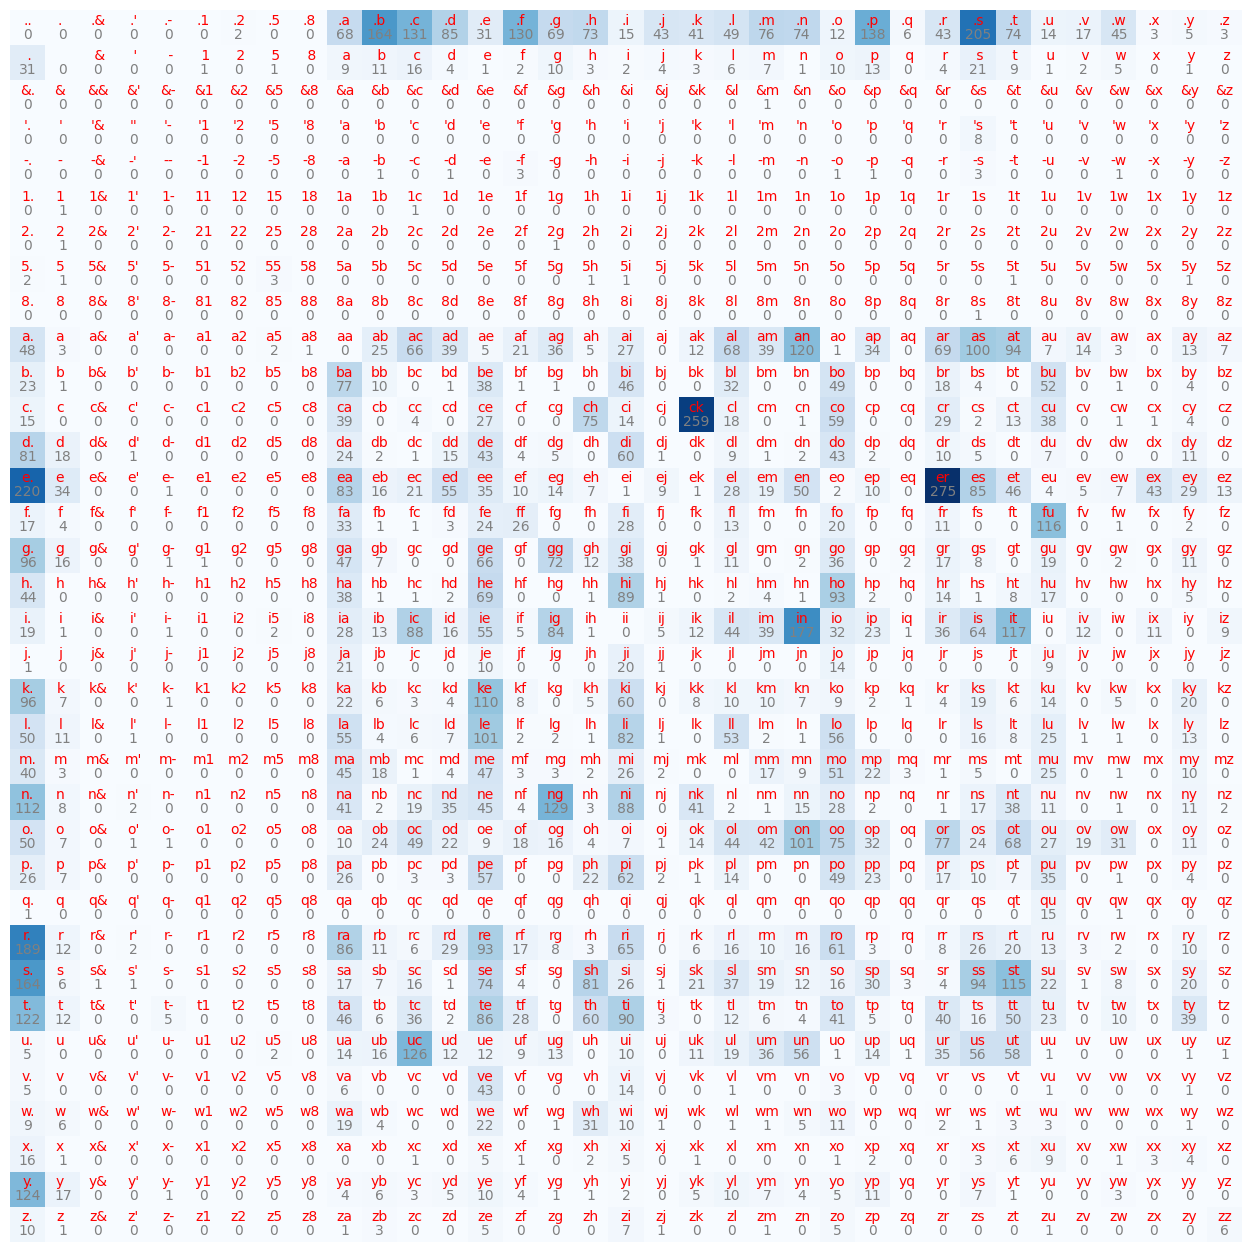

In [51]:
# let's visualize the tensors 

plt.figure(figsize = (16, 16)) 
plt.imshow(N, cmap="Blues")

for i in range(35): # 34 is for number of unique characters in the dataset + "." character so = 35 chars 
    for j in range(35): 
        chstr = itos[i] + itos[j] 
        plt.text(j, i, chstr, ha = "center", va = "bottom", color = "red")
        plt.text(j, i, N[i,j].item(), ha = "center", va = "top", color = "gray")

plt.axis("off"); 

In [52]:
# let's take a first row probabilities and normalizes those 
p = N[0].float() ## taking the first row and converting to float because we need to normalize 
p = p /p.sum() ## normalizing 
print(f"After normalizing: {p} \nsum is {p.sum()}")



After normalizing: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.0000, 0.0000,
        0.0421, 0.1015, 0.0811, 0.0526, 0.0192, 0.0804, 0.0427, 0.0452, 0.0093,
        0.0266, 0.0254, 0.0303, 0.0470, 0.0458, 0.0074, 0.0854, 0.0037, 0.0266,
        0.1269, 0.0458, 0.0087, 0.0105, 0.0278, 0.0019, 0.0031, 0.0019]) 
sum is 1.0


In [53]:
# let's sample this gaussian distribution(normalized probabilites) using torch multinomial functions 

g = torch.Generator().manual_seed(2147483647) ## it always generates the same result 
ix = torch.multinomial(p, num_samples=10, replacement=True, generator=g) ## multinomial  helps to sample from gaussian distribution 
## takes gaussian distribution as input and output the index. Sampling based on the probabilites 

ix ## this ix is always same 

tensor([24, 27, 24, 10, 10, 28, 28, 10, 22, 24])

In [54]:
## let's see how our bigram model is working :) 

g = torch.Generator().manual_seed(2147483647) ## setting manual seed, it outputs same very time !! 

for _ in range(10): 
    ix = 0 
    out = []
    while True: 
        p = N[ix].float()  # Randomly sampling the rows 
        p = p / p.sum()    # normalizing the sampled rows 
        # p = torch.ones(35) / 35.0  ## try with commeting previous 2 lines (this is untrained) (previous 2 lines are like trained model)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        out.append(itos[ix])
        if ix == 0: break; # 0 means "." that's why we are stopping it : ) 

    print("".join(out))

butack.
biching.
h.
mingse.
ves.
baledleraswe.
lore.
ketfucotatadenataconggaterass.
uk.
biafur.


In [55]:
## our previous code is working fine but this is in-efficient way. So let's code better. 

### Sometime model outputs 0 probabilities this is because there is no occurence in the tensor. If you take log of 0 is (-infinity)
### This is not good because in later we will take log of each prob. So we can add some duplicate count. 
### This duplicate cound is called "Model Smoothing !!"

# adding fake counts (model smoothing)
P = (N+1).float()
P /= P.sum(dim = 1, keepdim=True)  # here we are doing broad-casting (look in pytorch)
g = torch.Generator().manual_seed(2147483647) 

for _ in range(10): 
    ix = 0 
    out = []
    while True: 
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        out.append(itos[ix])
        if ix == 0: break; # 0 means "." that's why we are stopping it : ) 

    print("".join(out))


# the output is exact same results but we used broadcasting here :) it's faster :: 

butack.
biching.
h.
mingse.
ves.
baledleraswe.
lore.
ketfucotatadenataco&-uaterass.
ukfaiafur.
golerennemelos2glleeber.


In [14]:
# we just trained a bigram model by just conunting the inupt characters. 
## Let's calculate the quality of the model :) 
### To calculate this will use the "Max likelihood prob"

"""
Maximum Likelihood probability: 

-> Likelihood means product of all the probabilities. 
-> The product of all probabilities (likelihood) should be as high as possible, that is maximum probability.
-> Mostly the probabilities are in the range between 0 to 1, if you product all your probabilites(likelihood) it will be very small number.
-> So, because of this issue, people always work with log-likelihood. 
-> Simply we take the log of the probability is log-likelihood. 
-> Log is just a monotonic transformation of the probability. 
-> If you pass 1(probability) to log you get you 0 (good) probaility, as you go lower and lower probability like -2, -4 the log will grow more and more negative until all the way to negative infinity probability.  

## intuitive way :) 
probs = [0003432.23, 002.077, 004.07898]
probs1 = [0003432.23, 002.077, 004.07898]
probs2 = [0003432.23, 002.077, 004.07898]

likelihood -> probs * probs1 * probs2 => likelihood 
log(likelihood) -> log(probs) + log(probs1) + log(probs2) => log(likelihood) 

----- 
Likelihood is product of the probabilites 
Log-likelihood is sum of the log of the individual probabilities
-----

Here the catch is if all the prob is nearly 1 (high), the likelihood is zero.  
If all the prob is negative (bad), the likelihood will grow more and more negative.  

The problem is in loss function, it assumes low is good but our Max log prob is inverse of this. 
So, to solve this they added inverse sign to the existing form. 

This is called "negative log likelihood" just adding negative sign to previous form. 
So now we need to minimize this, because we added the negative sign 


## intuitive way :) 
probs = [0003432.23, 002.077, 004.07898]
probs1 = [0003432.23, 002.077, 004.07898]
probs2 = [0003432.23, 002.077, 004.07898]

likelihood -> probs * probs1 * probs2 => likelihood 
log(likelihood) -> log(probs) + log(probs1) + log(probs2) => log(likelihood) 
negative log(likelihood) -> -(log(probs) + log(probs2) + log(probs2)) => negative log(likelihood)

Someimtes people calculate the average of the negative log likelihood for more simplicity. 
Here also we need to minimize the avg negative log likehlihood because it's inverse of log likelihood.
"""


## let's see the probability assigned to bigrams by model :) 

log_likelihood = 0.0  # just initializing the var 
count = 0
for w in data:#[:2]:  
    chs = ["."] + list(w) + ["."]  
    for ch1, ch2 in zip(chs, chs[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2] 
        prob = P[ix1, ix2] # gettting the probabilty 
        logprob = torch.log(prob) # log (probability) 
        log_likelihood += logprob
        print(f"Bigram: {ch1}{ch2} | prob: {prob:.4f} | nll: {log_likelihood:.4f}")
        count += 1


nll = -log_likelihood /count  ## calclating the average of negative log likelihood 
print(f"\n{nll=}")

## our ultimte aim to build a model that reduce this negative log likelihood loss 

## You can also check probability for your own data. Instead of data in for loop give your own words 
## Example: for i in ["aravind"]

Bigram: .m | prob: 0.0466 | nll: -3.0653
Bigram: mo | prob: 0.1394 | nll: -5.0357
Bigram: ou | prob: 0.0342 | nll: -8.4115
Bigram: un | prob: 0.1048 | nll: -10.6674
Bigram: nd | prob: 0.0519 | nll: -13.6250
Bigram: d  | prob: 0.0500 | nll: -16.6207
Bigram:  o | prob: 0.0516 | nll: -19.5841
Bigram: of | prob: 0.0232 | nll: -23.3477
Bigram: f  | prob: 0.0149 | nll: -27.5524
Bigram:  v | prob: 0.0141 | nll: -31.8151
Bigram: ve | prob: 0.4037 | nll: -32.7223
Bigram: en | prob: 0.0440 | nll: -35.8449
Bigram: nu | prob: 0.0173 | nll: -39.9010
Bigram: us | prob: 0.1048 | nll: -42.1569
Bigram: s. | prob: 0.1974 | nll: -43.7796
Bigram: .a | prob: 0.0418 | nll: -46.9546
Bigram: as | prob: 0.1130 | nll: -49.1352
Bigram: ss | prob: 0.1136 | nll: -51.3100
Bigram: sl | prob: 0.0455 | nll: -54.4010
Bigram: lo | prob: 0.1067 | nll: -56.6383
Bigram: ov | prob: 0.0244 | nll: -60.3507
Bigram: ve | prob: 0.4037 | nll: -61.2578
Bigram: er | prob: 0.2383 | nll: -62.6919
Bigram: r. | prob: 0.2533 | nll: -64.

In [15]:
# We simply trained a bigram model using counts and we end with some-what results. 
# Now we change the gear to neural network, still it's a bigram model but we use "gradient descent" to optimize the loss function; 
# Let's start building the neural networks for our bigram model. 
## Note: Our neural network going to contain one hidden layer :) 

## The first step is to create a dataset for our model. Let's do it : ) 

In [58]:
# create the training set of all the bigrams 

xs, ys = [], []
for w in data[:1]: # currently we are doing it for single word (just for understanding !! )
    chs = ["."] + list(w) + ["."] 

    for ch1, ch2 in zip(chs, chs[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1); ys.append(ix2) # xs is like input and ys is like output (next character)

## let's convert to tensors 
xs = torch.tensor(xs) 
ys = torch.tensor(ys)  

## Here print xs[0] and ys[0]. 
## If the input is xs[0], the desired label would be ys[0]
print(f"If input is xs[0]: {itos[xs[0].item()]} the desired label would be ys[0]: {itos[ys[0].item()]}")
print(f"If input is xs[1]: {itos[xs[1].item()]} the desired label would be ys[1]: {itos[ys[1].item()]}")

If input is xs[0]: . the desired label would be ys[0]: m
If input is xs[1]: m the desired label would be ys[1]: o


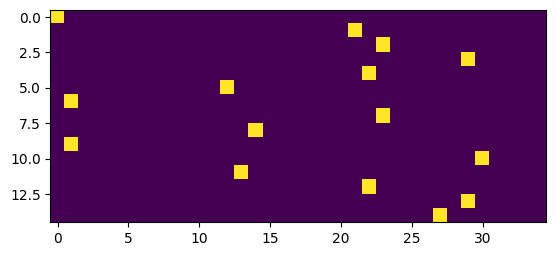

In [59]:
## Now we created a training data, now let's see how to feed this to the model :) 
## The problem is we can't directly send this integers to the model, so let's convert this integers to one hot vectors. Pytorch has the function 

import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes= 35).float()  # we are casting the one hot to float because neurons except like this :) 
plt.imshow(xenc);

In [60]:
## let's initialize the weights for our model and multipley with 

W = torch.randn((35, 35))  # 35 -> number of unique characters 
xenc @ W  ## @ --> matrix multiplication operator 
## [15, 35] x [35, 35]  ==> (15, 35) output shape
## xenc.shape x W.shape

tensor([[-1.0400,  0.0441, -1.3624, -1.2079, -0.0035,  0.9026, -0.1026,  0.9106,
          0.4065,  0.1689,  1.4212,  0.4559, -0.4924, -1.3990,  0.3903,  0.7698,
         -0.1067,  0.3271,  0.8358, -1.3211, -0.1307,  0.3192, -0.8392,  0.4163,
          1.4121,  0.6199,  1.0891,  0.7709,  1.4927, -1.7631, -0.6014,  0.8289,
          0.4709, -0.0966, -0.5037],
        [ 1.4732,  1.7493, -0.0963,  0.9757,  0.3469,  0.1042,  0.8517,  0.9005,
          0.8200,  0.1866,  1.8885, -1.6515, -0.1875,  0.3480,  0.4734,  1.5282,
         -0.1713, -0.8307,  0.8135,  1.7071,  1.2609, -0.9841,  0.3387,  2.8431,
         -0.7258,  0.3162,  1.5496, -1.5097,  0.9435,  1.8485,  0.5430, -0.6068,
          0.8453, -0.4501,  1.3500],
        [-0.7842, -2.1068, -1.3965, -1.8047, -0.5424,  0.2606,  0.4057,  0.1716,
          2.0276, -0.8124, -1.0029,  1.6854,  1.2616,  2.3840,  1.1024,  1.8563,
         -0.7985,  1.0913, -0.4454,  0.7334, -2.4487, -0.5937,  0.5230,  0.1769,
          0.8616,  0.3186,  0.3841,

In [61]:
## now we build a one hidden layer for our model, now let's try to find the output. 
## Modle outputs some positive and negative integers which don't make any sense for us. We need a output which represents the next character probability. 
## Basically our model outputs the "log counts", now we need to get only counts from this to remove the log we use exponential. 


"""
Exponential: 
-> It takes both positive and negative numbers. 
-> If you pluging negative numbers you get output bellow 1 to infinity. 
-> If you plugig greater than 1 you always get output greater than 1 always to infinity. 
"""

## let's do that exponential 
logits = xenc @ W # log-of-counts is called logits 
counts = logits.exp()
probs = counts / counts.sum(dim = 1, keepdims = True)  # just normalizing the rows 
probs 

## The last 2 line of code is just a softmax algorithm :) 

tensor([[0.0067, 0.0199, 0.0049, 0.0057, 0.0190, 0.0470, 0.0172, 0.0474, 0.0286,
         0.0226, 0.0790, 0.0301, 0.0117, 0.0047, 0.0282, 0.0412, 0.0171, 0.0265,
         0.0440, 0.0051, 0.0167, 0.0262, 0.0082, 0.0289, 0.0783, 0.0354, 0.0567,
         0.0412, 0.0849, 0.0033, 0.0105, 0.0437, 0.0305, 0.0173, 0.0115],
        [0.0454, 0.0599, 0.0095, 0.0276, 0.0147, 0.0116, 0.0244, 0.0256, 0.0236,
         0.0125, 0.0688, 0.0020, 0.0086, 0.0147, 0.0167, 0.0480, 0.0088, 0.0045,
         0.0235, 0.0574, 0.0367, 0.0039, 0.0146, 0.1787, 0.0050, 0.0143, 0.0490,
         0.0023, 0.0267, 0.0661, 0.0179, 0.0057, 0.0242, 0.0066, 0.0402],
        [0.0057, 0.0015, 0.0031, 0.0021, 0.0072, 0.0162, 0.0187, 0.0148, 0.0947,
         0.0055, 0.0046, 0.0672, 0.0440, 0.1352, 0.0375, 0.0798, 0.0056, 0.0371,
         0.0080, 0.0259, 0.0011, 0.0069, 0.0210, 0.0149, 0.0295, 0.0171, 0.0183,
         0.0268, 0.0354, 0.0580, 0.0093, 0.0052, 0.0638, 0.0191, 0.0592],
        [0.0350, 0.0166, 0.0693, 0.0026, 0.0262, 

In [62]:
## summary of all the neural network stuff 
 
n = 15
nlls = torch.zeros(n)
for i in range(n): 
    x = xs[i].item()  ## grabbing the input 
    y = ys[i].item()  ## grabbing the output 
    print(f"Input: {itos[x]}, Desired output: {itos[y]}")

    logits = probs[i, y]   ## grabbing the probabilites for (input  and  output)
    # from the model (it tells that probability of each character after the input, it tells the probability of each character occuring next 
    print(f"Outupt logit: {probs[i]}")
    print(f"The probability of our desired next character {itos[y]} is : {logits}")
    loglogits = torch.log(logits) ## log of counts 
    nll = -loglogits ## negative log likelihood 
    print(f"Negative log likelihood: {nll}")
    nlls[i] = nll 
    print(f"{'-'*19}\n")

print(f"average log likelihood is {nlls.mean().item()}")


Input: ., Desired output: m
Outupt logit: tensor([0.0067, 0.0199, 0.0049, 0.0057, 0.0190, 0.0470, 0.0172, 0.0474, 0.0286,
        0.0226, 0.0790, 0.0301, 0.0117, 0.0047, 0.0282, 0.0412, 0.0171, 0.0265,
        0.0440, 0.0051, 0.0167, 0.0262, 0.0082, 0.0289, 0.0783, 0.0354, 0.0567,
        0.0412, 0.0849, 0.0033, 0.0105, 0.0437, 0.0305, 0.0173, 0.0115])
The probability of our desired next character m is : 0.026241740211844444
Negative log likelihood: 3.640403985977173
-------------------

Input: m, Desired output: o
Outupt logit: tensor([0.0454, 0.0599, 0.0095, 0.0276, 0.0147, 0.0116, 0.0244, 0.0256, 0.0236,
        0.0125, 0.0688, 0.0020, 0.0086, 0.0147, 0.0167, 0.0480, 0.0088, 0.0045,
        0.0235, 0.0574, 0.0367, 0.0039, 0.0146, 0.1787, 0.0050, 0.0143, 0.0490,
        0.0023, 0.0267, 0.0661, 0.0179, 0.0057, 0.0242, 0.0066, 0.0402])
The probability of our desired next character o is : 0.17873473465442657
Negative log likelihood: 1.7218525409698486
-------------------

Input: o, Desi

In [63]:
## let's see full network 

# randomly initialize 35 neurons weights. Each neuron  receives 35 inputs 
g = torch.Generator().manual_seed(2179879798)
W = torch.randn( (35, 35), generator=g, requires_grad=True) 

In [64]:

# forward pass 
xnec = F.one_hot(xs, num_classes=35).float()
logits = xenc @ W 
counts = logits.exp() 
probs = counts / counts.sum(dim=1, keepdims=True)  # outputs probability of all the characters.      
loss = -probs[torch.arange(len(xnec)), ys].log().mean()  # negative log probability 
print(loss)

tensor(3.7921, grad_fn=<NegBackward0>)


In [65]:
## backward pass 
W.grad = None  ## set to zero gradient 
loss.backward() 

In [66]:
## update the weights 
W.data += -00.1 * W.grad 

In [71]:
## 1. Let's put it all together 

# creating a dataset 
xs, ys = [], []
for w in data: 
    chs = ["."] + list(w) + ["."] 

    for ch1, ch2 in zip(chs, chs[1:]): 
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1); ys.append(ix2) 

## let's convert to tensors 
xs = torch.tensor(xs) 
ys = torch.tensor(ys)  

num = xs.nelement()
print(f"Number of elements: {num}")

# randomly initialize 27 neurons weights. Each neuron  receives 27 inputs 
g = torch.Generator().manual_seed(2179879798)
W = torch.randn( (35, 35), generator=g, requires_grad=True) 

Number of elements: 13649


In [76]:
## 2. let's put it all together 

# Gradient descent 
n = 1000 
for k in range(n):
     # forward pass 
    xnec = F.one_hot(xs, num_classes=35).float()
    logits = xnec @ W 
    counts = logits.exp() 
    probs = counts / counts.sum(dim=1, keepdims=True)  # outputs probability of all the characters.      
    loss = -probs[torch.arange(len(xnec)), ys].log().mean()  # negative log probability 
    loss += 0.01*(W**2).mean() # adding regularization because we are initializing random index, sometimes it may have lot of zeros. If we have lot of zeros our loss will get high. so we are doing it. 
    print(f"Loss of iteration: {k}: {loss.item()}") 

    ## backward pass 
    W.grad = None  ## set to zero gradient 
    loss.backward() 

    ## update the weights 
    W.data += -160* W.grad 

Loss of iteration: 0: 2.5691263675689697
Loss of iteration: 1: 2.5691263675689697
Loss of iteration: 2: 2.5691263675689697
Loss of iteration: 3: 2.5691261291503906
Loss of iteration: 4: 2.5691261291503906
Loss of iteration: 5: 2.5691261291503906
Loss of iteration: 6: 2.5691261291503906
Loss of iteration: 7: 2.5691261291503906
Loss of iteration: 8: 2.5691261291503906
Loss of iteration: 9: 2.5691261291503906
Loss of iteration: 10: 2.5691261291503906
Loss of iteration: 11: 2.5691258907318115
Loss of iteration: 12: 2.5691256523132324
Loss of iteration: 13: 2.5691256523132324
Loss of iteration: 14: 2.5691258907318115
Loss of iteration: 15: 2.5691258907318115
Loss of iteration: 16: 2.5691256523132324
Loss of iteration: 17: 2.5691258907318115
Loss of iteration: 18: 2.5691258907318115
Loss of iteration: 19: 2.5691263675689697
Loss of iteration: 20: 2.5691280364990234
Loss of iteration: 21: 2.569134473800659
Loss of iteration: 22: 2.5691568851470947
Loss of iteration: 23: 2.569242000579834
Loss

In [78]:
## 3. let's put it all together 
g = torch.Generator().manual_seed(2147483647) 
## Inferencing
for i in range(10): 
    out = [] 
    ix = 0 

    while True: 
        xnec_test = F.one_hot(torch.tensor([ix]), num_classes=35).float()
        logits = xnec_test @ W 
        count = logits.exp() 
        p = count/count.sum(1, keepdims = True)
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator= g).item() # doubt -> after getting softmax why we are again sampling from the softmax distribution? 
        out.append(itos[ix]) 

        if ix == 0: break; 

    print("".join(out))


butack.
biching.
h.
bingseaves.
baledlerasweriorenketfucktatadenataconggaterass.
uk.
biafur.
colerennemelos2g.
leeber.
fuk.


In [ ]:
# If you notice neural network output and bigram output are same. 
# basically both are doing the same but we came the solution with different angle. 
# because of bigram model, instead of giving bigram representation, here we are giving neural network representation 